In [ ]:
import duckdb
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Подключаемся к базе
con = duckdb.connect(database=":memory:", read_only=False)

# Загружаем CSV-файлы
con.execute("CREATE TABLE orders AS SELECT * FROM read_csv_auto('Sales Data/orders.csv');")
con.execute("CREATE TABLE order_details AS SELECT * FROM read_csv_auto('Sales Data/order_details.csv');")
con.execute("CREATE TABLE pizzas AS SELECT * FROM read_csv_auto('Sales Data/pizzas.csv');")
con.execute("CREATE TABLE pizza_types AS SELECT * FROM read_csv_auto('Sales Data/pizza_types.csv');")

# Формируем нужные данные
query = """
SELECT 
    orders.date,
    orders.time,
    pizza_types.category,
    order_details.quantity,
    pizzas.price
FROM orders
JOIN order_details ON orders.order_id = order_details.order_id
JOIN pizzas ON order_details.pizza_id = pizzas.pizza_id
JOIN pizza_types ON pizzas.pizza_type_id = pizza_types.pizza_type_id
"""

df = con.execute(query).fetchdf()

# Объединяем дату и время в один столбец

df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

# Убираем ненужные столбцы
df = df[['datetime', 'category', 'quantity', 'price']]

# Агрегируем продажи по дате
df = df.groupby('datetime').agg({'quantity': 'sum', 'price': 'mean'}).reset_index()


# Создаем признаки (например, день недели, месяц, час)
df['day_of_week'] = df['datetime'].dt.dayofweek
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
# df['day'] = df['datetime'].dt.day

# Разбиваем данные на X и y
X = df[['day_of_week', 'hour', 'month',  'price']]
y = df['quantity']


             datetime category  quantity  price
0 2015-01-01 11:38:36  Classic         1  13.25
1 2015-01-01 11:57:40  Classic         1  16.00
2 2015-01-01 11:57:40   Veggie         1  18.50
3 2015-01-01 11:57:40  Supreme         1  20.75
4 2015-01-01 11:57:40   Veggie         1  16.00
             datetime  quantity   price
0 2015-01-01 11:38:36         1  13.250
1 2015-01-01 11:57:40         5  18.400
2 2015-01-01 12:12:28         2  18.625
3 2015-01-01 12:16:31         1  16.500
4 2015-01-01 12:21:30         1  16.500


In [19]:
df

,datetime,quantity,price,day_of_week,hour,month
0,2015-01-01 11:38:36,1,13.250000,3,11,1
1,2015-01-01 11:57:40,5,18.400000,3,11,1
2,2015-01-01 12:12:28,2,18.625000,3,12,1
3,2015-01-01 12:16:31,1,16.500000,3,12,1
4,2015-01-01 12:21:30,1,16.500000,3,12,1
...,...,...,...,...,...,...
21345,2015-12-31 20:51:07,4,15.562500,3,20,12
21346,2015-12-31 21:14:37,4,16.625000,3,21,12
21347,2015-12-31 21:23:10,3,15.566667,3,21,12
21348,2015-12-31 22:09:54,1,20.250000,3,22,12


In [16]:
# Разделение на train и test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создаем и обучаем модель LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31
}



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 270
[LightGBM] [Info] Number of data points in the train set: 17080, number of used features: 4
[LightGBM] [Info] Start training from score 2.328689
MAE: 0.716


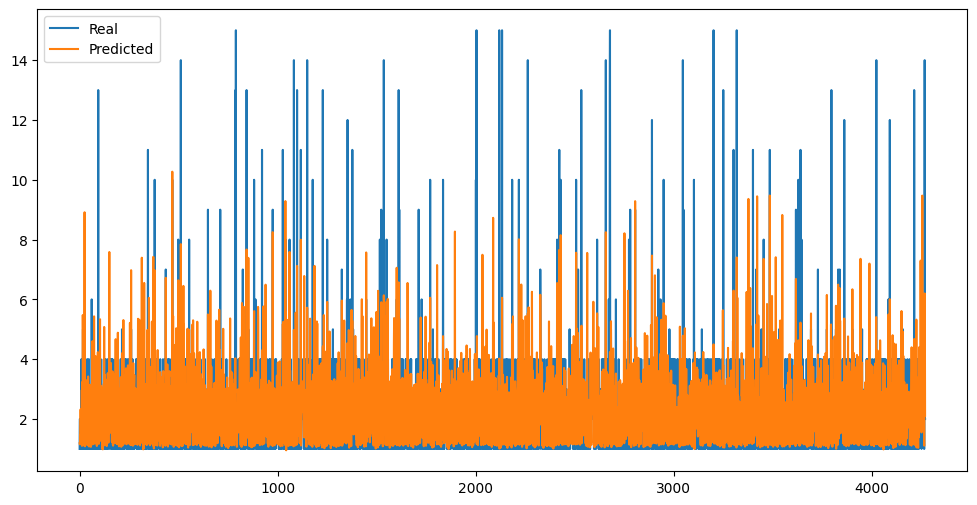

In [18]:
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=100)

# Делаем прогноз
y_pred = model.predict(X_test)

# Оцениваем качество модели
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.3f}")

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Real")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.show()